In [1]:
import sys, os
import scipy.sparse as sps
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

sys.path.append(os.path.abspath('../kernel_inference'))
from new_york_inference import load

%matplotlib inline

In [2]:
kernel = load('../kernel_inference/filtered_paths2.txt')

In [3]:
def get_matrix(kernel, dt):
    keys = set(kernel.keys())
    for ends in kernel.values():
        keys.update(ends.keys())
    keys = sorted(keys)
    base = 1/float(len(keys))

    mat = []
    for start in keys:
        row = []
        for end in keys:
            row.append(sum(1 for t in kernel[start][end] if t < dt))
        total = float(sum(row))
        mat.append([r / total for r in row] if total > 0 else [base] * len(keys))
    return np.array(mat, np.float64)
        
slice = get_matrix(kernel, 360)
        

In [30]:
plt.hist(map(np.count_nonzero, slice))
plt.title('Number of non-zero entries in each row of adjacency matrix')
plt.show()

In [31]:
sc = plt.matshow(slice, cmap=cm.Blues,vmin=0.00001, vmax=1,norm=colors.LogNorm())
plt.colorbar(sc).set_label('Probability')
plt.show()

Find the eigenvalues of the matrix:

In [4]:
w, v = np.linalg.eig(slice)

In [13]:
plt.plot(sorted(map(np.abs, w)))
plt.title('Absolute value of eigenvalues')
plt.show()

In [16]:
sorted(map(np.abs, w))[-10:]

[0.74025532743589628,
 0.74025532743589628,
 0.74645094166820747,
 0.75748773732631958,
 0.80479860240282752,
 0.81253375276528561,
 0.86514438394604476,
 0.90082389010633857,
 0.93198384847107052,
 1.0000000000000075]

In [15]:
spec = sps.linalg.svds(slice.T, k=100, return_singular_vectors=False)
plt.plot(spec)

Symmetrize the adjacency matrix $A$:

\frac{A + A^T}{2}

And make sure it is row-stochastic

In [ ]:
symmetric = (slice + slice.T) / 2

Iteratively make the matrix doubly stochastic

In [33]:
def normalize_rows(matrix):
    return np.array([row / float(sum(row)) for row in matrix])

def iter_norm(mat, n):
    for _ in range(30):
        mat = normalize_rows(mat.T)
    return mat

#print set(round(sum(r),5) for r in slice)
#print set(round(sum(r),5) for r in slice.T)

In [32]:
spec = sps.linalg.svds(slice, k=1000, return_singular_vectors=False)
plt.plot(spec)

In [39]:
g = nx.from_numpy_matrix(slice)
lspec = nx.laplacian_spectrum(g)
aspec = nx.adjacency_spectrum(g)

In [40]:
plt.plot(sorted(aspec))
plt.show()
plt.plot(sorted(lspec))
plt.show()
print lspec[-2]

/usr/lib/python2.7/site-packages/numpy/core/numeric.py:462: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


3.57565373426


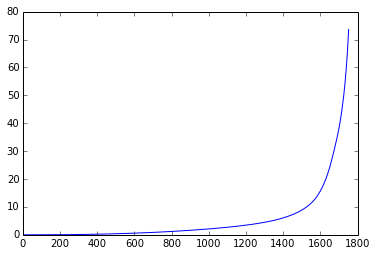

In [18]:
plt.plot(np.cumsum(sorted([a**2 for a in aspec])))
plt.show()

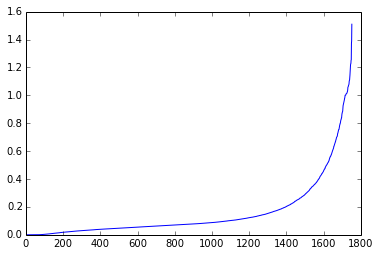

In [19]:
plt.plot(sorted(np.linalg.svd(slice, compute_uv=0)))

In [16]:
sparse = sps.coo_matrix(symmetric)

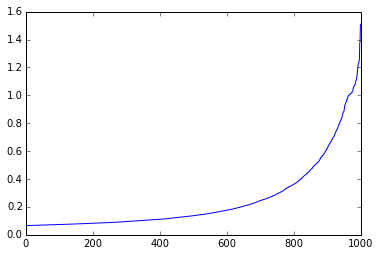

In [23]:
spec = sps.linalg.svds(slice, k=1000, return_singular_vectors=False)
plt.plot(spec)